# 프로젝트 : Segmentation map으로 도로 이미지 만들기

이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다.  
데이터셋은 아래에서 다운로드 할 수 있습니다.  
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.  

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.

아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.  
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)  

https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 1 가지 이상의 augmentation 방법을 적용하여 학습해주세요. (어떠한 방법을 사용했는지 적어주세요).

2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.

3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내에서 아무 이미지나 사용해주세요.
1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 (스케치, 생성된 사진, 실제 사진) 순서로 나란히 시각화해 주세요.

4. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [2]:
import os
train_data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'

In [3]:
print("number of train examples :", len(os.listdir(train_data_path)))

number of train examples : 1000


In [4]:
val_data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

In [5]:
print("number of val examples :", len(os.listdir(val_data_path)))

number of val examples : 5


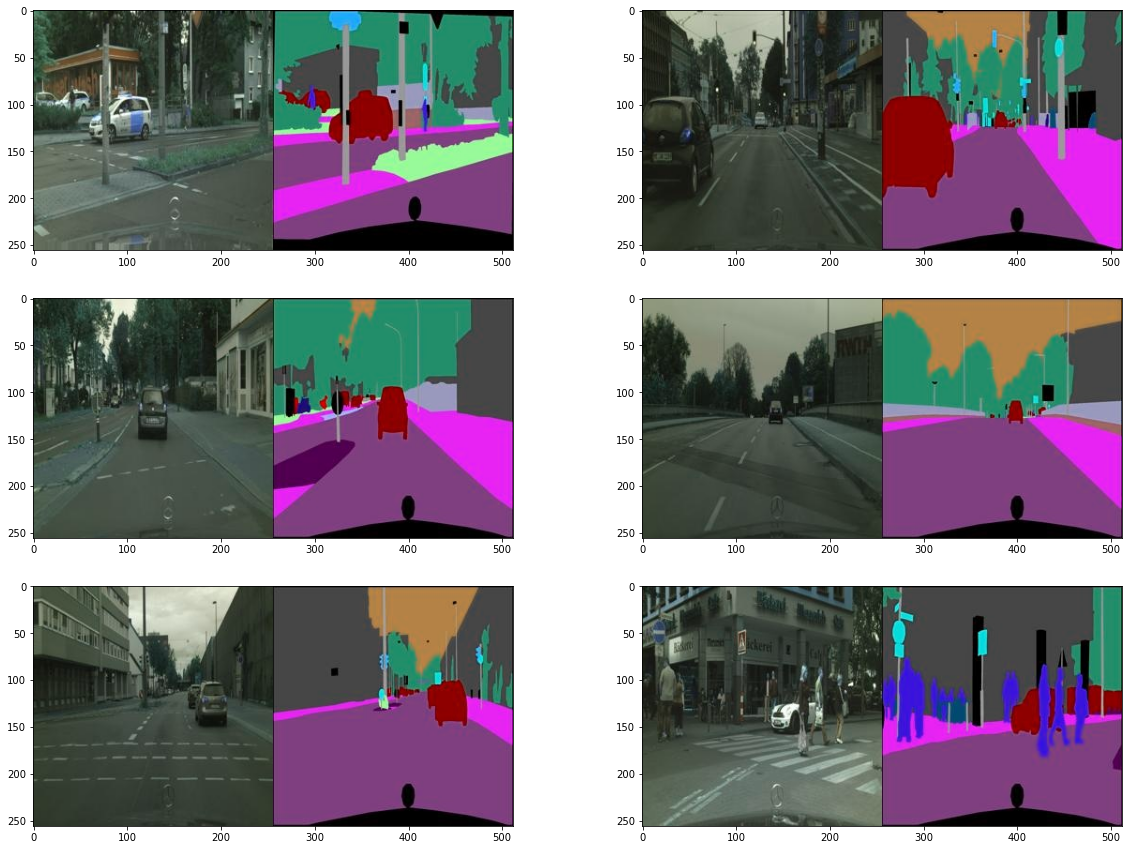

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [8]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [9]:
f_val = val_data_path + os.listdir(val_data_path)[0]
img_val = cv2.imread(f_val, cv2.IMREAD_COLOR)
print(img_val.shape)

(256, 512, 3)


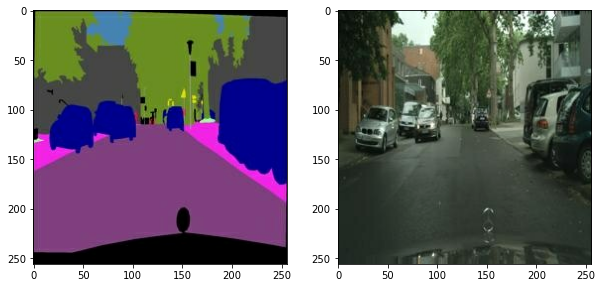

In [11]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [12]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


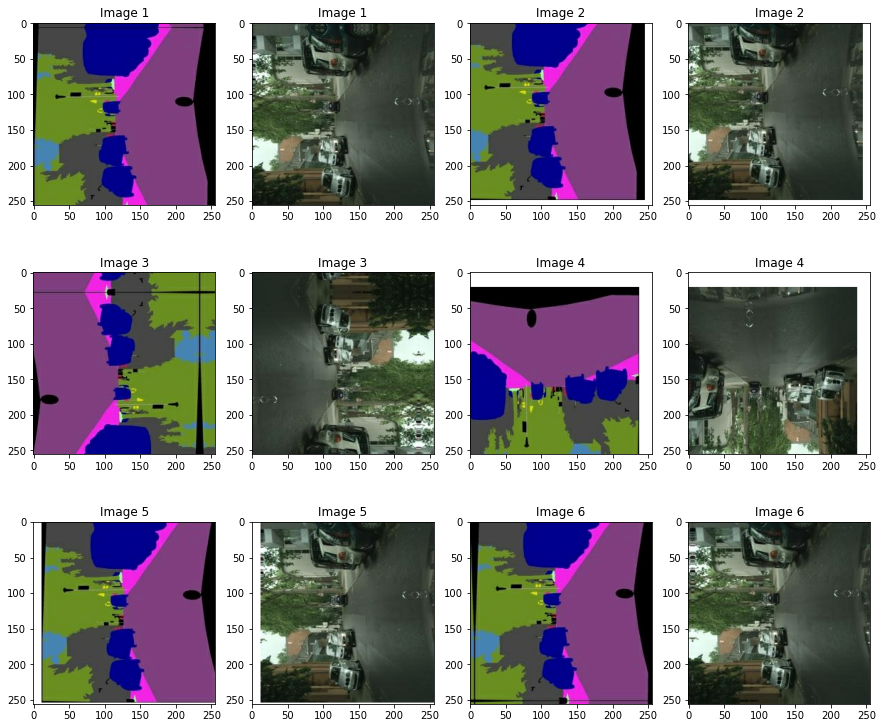

In [13]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

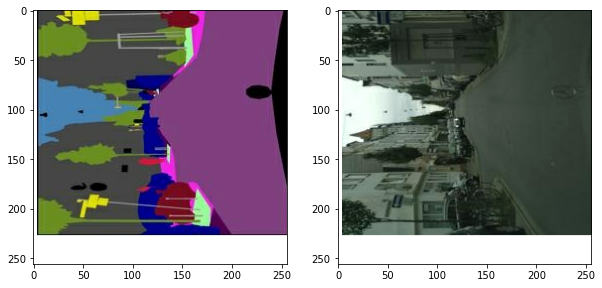

In [15]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [16]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [17]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [18]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [19]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [20]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [21]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [22]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [23]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [24]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

In [25]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [26]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [27]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [28]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

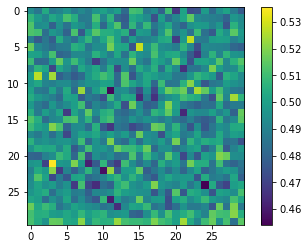

In [29]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [30]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [31]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [32]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [33]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8154                     
L1_loss:0.3463                     
Discriminator_loss:1.3153

EPOCH[1] - STEP[20]                     
Generator_loss:0.8419                     
L1_loss:0.2646                     
Discriminator_loss:1.4425

EPOCH[1] - STEP[30]                     
Generator_loss:0.9694                     
L1_loss:0.1932                     
Discriminator_loss:1.3250

EPOCH[1] - STEP[40]                     
Generator_loss:0.9599                     
L1_loss:0.1565                     
Discriminator_loss:1.3283

EPOCH[1] - STEP[50]                     
Generator_loss:0.9865                     
L1_loss:0.1836                     
Discriminator_loss:1.1674

EPOCH[1] - STEP[60]                     
Generator_loss:1.0949                     
L1_loss:0.2029                     
Discriminator_loss:1.0019

EPOCH[1] - STEP[70]                     
Generator_loss:1.2674                     
L1_loss:0.1748                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.2049                     
L1_loss:0.1663                     
Discriminator_loss:1.1669

EPOCH[3] - STEP[80]                     
Generator_loss:1.8868                     
L1_loss:0.1864                     
Discriminator_loss:0.7236

EPOCH[3] - STEP[90]                     
Generator_loss:1.2916                     
L1_loss:0.1614                     
Discriminator_loss:0.8679

EPOCH[3] - STEP[100]                     
Generator_loss:2.8416                     
L1_loss:0.1570                     
Discriminator_loss:2.8696

EPOCH[3] - STEP[110]                     
Generator_loss:1.8033                     
L1_loss:0.1812                     
Discriminator_loss:1.5547

EPOCH[3] - STEP[120]                     
Generator_loss:1.9797                     
L1_loss:0.1636                     
Discriminator_loss:0.6013

EPOCH[3] - STEP[130]                     
Generator_loss:2.4762                     
L1_loss:0.1793                

EPOCH[5] - STEP[130]                     
Generator_loss:2.0474                     
L1_loss:0.1623                     
Discriminator_loss:1.1692

EPOCH[5] - STEP[140]                     
Generator_loss:1.8139                     
L1_loss:0.1506                     
Discriminator_loss:0.8902

EPOCH[5] - STEP[150]                     
Generator_loss:0.9454                     
L1_loss:0.2072                     
Discriminator_loss:0.7104

EPOCH[5] - STEP[160]                     
Generator_loss:0.7754                     
L1_loss:0.1824                     
Discriminator_loss:0.8177

EPOCH[5] - STEP[170]                     
Generator_loss:1.9207                     
L1_loss:0.1606                     
Discriminator_loss:1.7412

EPOCH[5] - STEP[180]                     
Generator_loss:0.8540                     
L1_loss:0.1627                     
Discriminator_loss:0.8276

EPOCH[5] - STEP[190]                     
Generator_loss:1.1667                     
L1_loss:0.2081             

EPOCH[7] - STEP[190]                     
Generator_loss:1.0581                     
L1_loss:0.1871                     
Discriminator_loss:0.5106

EPOCH[7] - STEP[200]                     
Generator_loss:0.5495                     
L1_loss:0.1967                     
Discriminator_loss:1.1328

EPOCH[7] - STEP[210]                     
Generator_loss:1.3395                     
L1_loss:0.1872                     
Discriminator_loss:0.4666

EPOCH[7] - STEP[220]                     
Generator_loss:1.1115                     
L1_loss:0.2243                     
Discriminator_loss:0.7326

EPOCH[7] - STEP[230]                     
Generator_loss:0.4001                     
L1_loss:0.2090                     
Discriminator_loss:1.3780

EPOCH[7] - STEP[240]                     
Generator_loss:1.5586                     
L1_loss:0.1992                     
Discriminator_loss:0.6990

EPOCH[7] - STEP[250]                     
Generator_loss:1.3717                     
L1_loss:0.1890             

EPOCH[9] - STEP[250]                     
Generator_loss:1.9443                     
L1_loss:0.1597                     
Discriminator_loss:2.0499

EPOCH[10] - STEP[10]                     
Generator_loss:0.9495                     
L1_loss:0.1780                     
Discriminator_loss:0.6077

EPOCH[10] - STEP[20]                     
Generator_loss:1.8868                     
L1_loss:0.1722                     
Discriminator_loss:0.2889

EPOCH[10] - STEP[30]                     
Generator_loss:0.1516                     
L1_loss:0.1914                     
Discriminator_loss:2.3437

EPOCH[10] - STEP[40]                     
Generator_loss:0.9197                     
L1_loss:0.1881                     
Discriminator_loss:0.9827

EPOCH[10] - STEP[50]                     
Generator_loss:2.0507                     
L1_loss:0.1827                     
Discriminator_loss:1.5493

EPOCH[10] - STEP[60]                     
Generator_loss:0.7662                     
L1_loss:0.1696             

EPOCH[12] - STEP[60]                     
Generator_loss:2.1809                     
L1_loss:0.2127                     
Discriminator_loss:0.1586

EPOCH[12] - STEP[70]                     
Generator_loss:0.7820                     
L1_loss:0.1863                     
Discriminator_loss:0.7531

EPOCH[12] - STEP[80]                     
Generator_loss:1.7743                     
L1_loss:0.1760                     
Discriminator_loss:0.9210

EPOCH[12] - STEP[90]                     
Generator_loss:2.3931                     
L1_loss:0.1985                     
Discriminator_loss:0.2460

EPOCH[12] - STEP[100]                     
Generator_loss:2.5741                     
L1_loss:0.1836                     
Discriminator_loss:0.3478

EPOCH[12] - STEP[110]                     
Generator_loss:1.4254                     
L1_loss:0.1421                     
Discriminator_loss:2.8437

EPOCH[12] - STEP[120]                     
Generator_loss:0.9427                     
L1_loss:0.2070          

EPOCH[14] - STEP[120]                     
Generator_loss:2.2977                     
L1_loss:0.1756                     
Discriminator_loss:2.2282

EPOCH[14] - STEP[130]                     
Generator_loss:2.2730                     
L1_loss:0.1434                     
Discriminator_loss:1.2110

EPOCH[14] - STEP[140]                     
Generator_loss:1.7654                     
L1_loss:0.1772                     
Discriminator_loss:0.7903

EPOCH[14] - STEP[150]                     
Generator_loss:1.9073                     
L1_loss:0.1735                     
Discriminator_loss:0.9708

EPOCH[14] - STEP[160]                     
Generator_loss:0.6795                     
L1_loss:0.1667                     
Discriminator_loss:1.1656

EPOCH[14] - STEP[170]                     
Generator_loss:0.5038                     
L1_loss:0.1727                     
Discriminator_loss:1.0876

EPOCH[14] - STEP[180]                     
Generator_loss:0.3267                     
L1_loss:0.1511      

EPOCH[16] - STEP[180]                     
Generator_loss:2.2681                     
L1_loss:0.1738                     
Discriminator_loss:0.6487

EPOCH[16] - STEP[190]                     
Generator_loss:1.9130                     
L1_loss:0.1682                     
Discriminator_loss:0.6175

EPOCH[16] - STEP[200]                     
Generator_loss:1.5067                     
L1_loss:0.1600                     
Discriminator_loss:0.7755

EPOCH[16] - STEP[210]                     
Generator_loss:1.4671                     
L1_loss:0.1729                     
Discriminator_loss:0.6296

EPOCH[16] - STEP[220]                     
Generator_loss:1.2263                     
L1_loss:0.1751                     
Discriminator_loss:0.6935

EPOCH[16] - STEP[230]                     
Generator_loss:1.3688                     
L1_loss:0.1705                     
Discriminator_loss:0.6388

EPOCH[16] - STEP[240]                     
Generator_loss:1.3316                     
L1_loss:0.1709      

EPOCH[18] - STEP[240]                     
Generator_loss:1.8595                     
L1_loss:0.1815                     
Discriminator_loss:0.2456

EPOCH[18] - STEP[250]                     
Generator_loss:1.8297                     
L1_loss:0.2072                     
Discriminator_loss:0.3588

EPOCH[19] - STEP[10]                     
Generator_loss:1.4769                     
L1_loss:0.1632                     
Discriminator_loss:0.4583

EPOCH[19] - STEP[20]                     
Generator_loss:2.1352                     
L1_loss:0.1740                     
Discriminator_loss:0.8607

EPOCH[19] - STEP[30]                     
Generator_loss:1.0498                     
L1_loss:0.1717                     
Discriminator_loss:1.0302

EPOCH[19] - STEP[40]                     
Generator_loss:1.3209                     
L1_loss:0.1529                     
Discriminator_loss:1.4955

EPOCH[19] - STEP[50]                     
Generator_loss:2.2840                     
L1_loss:0.1502           

EPOCH[21] - STEP[50]                     
Generator_loss:0.9689                     
L1_loss:0.1822                     
Discriminator_loss:0.6915

EPOCH[21] - STEP[60]                     
Generator_loss:1.6084                     
L1_loss:0.1595                     
Discriminator_loss:0.6184

EPOCH[21] - STEP[70]                     
Generator_loss:0.7692                     
L1_loss:0.1511                     
Discriminator_loss:1.1260

EPOCH[21] - STEP[80]                     
Generator_loss:1.3554                     
L1_loss:0.1782                     
Discriminator_loss:0.5949

EPOCH[21] - STEP[90]                     
Generator_loss:1.0886                     
L1_loss:0.2018                     
Discriminator_loss:0.5394

EPOCH[21] - STEP[100]                     
Generator_loss:1.5163                     
L1_loss:0.2011                     
Discriminator_loss:0.2943

EPOCH[21] - STEP[110]                     
Generator_loss:1.2050                     
L1_loss:0.1874           

EPOCH[23] - STEP[110]                     
Generator_loss:1.7839                     
L1_loss:0.1472                     
Discriminator_loss:1.3594

EPOCH[23] - STEP[120]                     
Generator_loss:0.6719                     
L1_loss:0.1696                     
Discriminator_loss:1.2546

EPOCH[23] - STEP[130]                     
Generator_loss:2.4110                     
L1_loss:0.1577                     
Discriminator_loss:2.7747

EPOCH[23] - STEP[140]                     
Generator_loss:1.0503                     
L1_loss:0.1927                     
Discriminator_loss:0.9027

EPOCH[23] - STEP[150]                     
Generator_loss:0.5215                     
L1_loss:0.1562                     
Discriminator_loss:2.0651

EPOCH[23] - STEP[160]                     
Generator_loss:0.5759                     
L1_loss:0.1803                     
Discriminator_loss:1.0349

EPOCH[23] - STEP[170]                     
Generator_loss:1.5448                     
L1_loss:0.1581      

EPOCH[25] - STEP[170]                     
Generator_loss:1.8930                     
L1_loss:0.1539                     
Discriminator_loss:1.6016

EPOCH[25] - STEP[180]                     
Generator_loss:0.9339                     
L1_loss:0.1650                     
Discriminator_loss:0.7090

EPOCH[25] - STEP[190]                     
Generator_loss:0.3827                     
L1_loss:0.1633                     
Discriminator_loss:1.4924

EPOCH[25] - STEP[200]                     
Generator_loss:1.3180                     
L1_loss:0.1844                     
Discriminator_loss:0.4030

EPOCH[25] - STEP[210]                     
Generator_loss:0.8042                     
L1_loss:0.1542                     
Discriminator_loss:1.3912

EPOCH[25] - STEP[220]                     
Generator_loss:1.7538                     
L1_loss:0.1932                     
Discriminator_loss:0.2432

EPOCH[25] - STEP[230]                     
Generator_loss:1.4110                     
L1_loss:0.1571      

EPOCH[27] - STEP[230]                     
Generator_loss:2.0332                     
L1_loss:0.2078                     
Discriminator_loss:0.2161

EPOCH[27] - STEP[240]                     
Generator_loss:1.5106                     
L1_loss:0.1895                     
Discriminator_loss:0.3273

EPOCH[27] - STEP[250]                     
Generator_loss:0.2670                     
L1_loss:0.1985                     
Discriminator_loss:1.9933

EPOCH[28] - STEP[10]                     
Generator_loss:0.9128                     
L1_loss:0.1707                     
Discriminator_loss:1.2821

EPOCH[28] - STEP[20]                     
Generator_loss:1.5323                     
L1_loss:0.1637                     
Discriminator_loss:1.2248

EPOCH[28] - STEP[30]                     
Generator_loss:1.7298                     
L1_loss:0.1841                     
Discriminator_loss:0.3674

EPOCH[28] - STEP[40]                     
Generator_loss:1.6260                     
L1_loss:0.1721          

EPOCH[30] - STEP[40]                     
Generator_loss:2.6548                     
L1_loss:0.1803                     
Discriminator_loss:0.4222

EPOCH[30] - STEP[50]                     
Generator_loss:1.3927                     
L1_loss:0.1966                     
Discriminator_loss:0.5152

EPOCH[30] - STEP[60]                     
Generator_loss:0.4313                     
L1_loss:0.1996                     
Discriminator_loss:1.1928

EPOCH[30] - STEP[70]                     
Generator_loss:1.1011                     
L1_loss:0.1804                     
Discriminator_loss:0.6231

EPOCH[30] - STEP[80]                     
Generator_loss:2.2281                     
L1_loss:0.1919                     
Discriminator_loss:0.2307

EPOCH[30] - STEP[90]                     
Generator_loss:2.8766                     
L1_loss:0.1748                     
Discriminator_loss:0.5643

EPOCH[30] - STEP[100]                     
Generator_loss:1.4232                     
L1_loss:0.1782            

EPOCH[32] - STEP[100]                     
Generator_loss:1.4364                     
L1_loss:0.1691                     
Discriminator_loss:0.5971

EPOCH[32] - STEP[110]                     
Generator_loss:1.8203                     
L1_loss:0.1908                     
Discriminator_loss:1.0663

EPOCH[32] - STEP[120]                     
Generator_loss:1.5919                     
L1_loss:0.1899                     
Discriminator_loss:1.2318

EPOCH[32] - STEP[130]                     
Generator_loss:0.9298                     
L1_loss:0.2101                     
Discriminator_loss:0.6172

EPOCH[32] - STEP[140]                     
Generator_loss:1.6660                     
L1_loss:0.1630                     
Discriminator_loss:0.6179

EPOCH[32] - STEP[150]                     
Generator_loss:2.7646                     
L1_loss:0.1925                     
Discriminator_loss:2.5890

EPOCH[32] - STEP[160]                     
Generator_loss:1.5616                     
L1_loss:0.1652      

EPOCH[34] - STEP[160]                     
Generator_loss:1.8523                     
L1_loss:0.1596                     
Discriminator_loss:0.3528

EPOCH[34] - STEP[170]                     
Generator_loss:0.9810                     
L1_loss:0.1421                     
Discriminator_loss:0.9466

EPOCH[34] - STEP[180]                     
Generator_loss:2.0238                     
L1_loss:0.1642                     
Discriminator_loss:1.1996

EPOCH[34] - STEP[190]                     
Generator_loss:1.4531                     
L1_loss:0.1800                     
Discriminator_loss:1.8016

EPOCH[34] - STEP[200]                     
Generator_loss:1.7058                     
L1_loss:0.1587                     
Discriminator_loss:2.7346

EPOCH[34] - STEP[210]                     
Generator_loss:1.9616                     
L1_loss:0.1609                     
Discriminator_loss:1.1622

EPOCH[34] - STEP[220]                     
Generator_loss:1.0757                     
L1_loss:0.1702      

EPOCH[36] - STEP[220]                     
Generator_loss:1.0421                     
L1_loss:0.1640                     
Discriminator_loss:0.6142

EPOCH[36] - STEP[230]                     
Generator_loss:1.2904                     
L1_loss:0.1906                     
Discriminator_loss:0.3751

EPOCH[36] - STEP[240]                     
Generator_loss:1.1759                     
L1_loss:0.1897                     
Discriminator_loss:0.8780

EPOCH[36] - STEP[250]                     
Generator_loss:1.6547                     
L1_loss:0.1514                     
Discriminator_loss:0.9038

EPOCH[37] - STEP[10]                     
Generator_loss:0.5362                     
L1_loss:0.1880                     
Discriminator_loss:1.0858

EPOCH[37] - STEP[20]                     
Generator_loss:0.7743                     
L1_loss:0.1430                     
Discriminator_loss:1.1607

EPOCH[37] - STEP[30]                     
Generator_loss:0.3357                     
L1_loss:0.1491         

EPOCH[39] - STEP[30]                     
Generator_loss:0.3058                     
L1_loss:0.1770                     
Discriminator_loss:1.7614

EPOCH[39] - STEP[40]                     
Generator_loss:1.5381                     
L1_loss:0.1740                     
Discriminator_loss:2.4700

EPOCH[39] - STEP[50]                     
Generator_loss:0.6549                     
L1_loss:0.1620                     
Discriminator_loss:1.1176

EPOCH[39] - STEP[60]                     
Generator_loss:1.1518                     
L1_loss:0.2296                     
Discriminator_loss:0.5207

EPOCH[39] - STEP[70]                     
Generator_loss:0.4801                     
L1_loss:0.1761                     
Discriminator_loss:2.2594

EPOCH[39] - STEP[80]                     
Generator_loss:2.1120                     
L1_loss:0.1529                     
Discriminator_loss:0.5004

EPOCH[39] - STEP[90]                     
Generator_loss:1.2504                     
L1_loss:0.1850             

EPOCH[41] - STEP[90]                     
Generator_loss:0.8453                     
L1_loss:0.1925                     
Discriminator_loss:0.8420

EPOCH[41] - STEP[100]                     
Generator_loss:1.6500                     
L1_loss:0.1537                     
Discriminator_loss:1.2270

EPOCH[41] - STEP[110]                     
Generator_loss:0.9280                     
L1_loss:0.1830                     
Discriminator_loss:0.5862

EPOCH[41] - STEP[120]                     
Generator_loss:1.4351                     
L1_loss:0.2181                     
Discriminator_loss:0.3180

EPOCH[41] - STEP[130]                     
Generator_loss:0.6756                     
L1_loss:0.1767                     
Discriminator_loss:1.1681

EPOCH[41] - STEP[140]                     
Generator_loss:0.2898                     
L1_loss:0.1649                     
Discriminator_loss:1.7448

EPOCH[41] - STEP[150]                     
Generator_loss:1.9693                     
L1_loss:0.1845       

EPOCH[43] - STEP[150]                     
Generator_loss:2.1987                     
L1_loss:0.1625                     
Discriminator_loss:0.2262

EPOCH[43] - STEP[160]                     
Generator_loss:0.9768                     
L1_loss:0.1731                     
Discriminator_loss:0.9139

EPOCH[43] - STEP[170]                     
Generator_loss:1.8120                     
L1_loss:0.1761                     
Discriminator_loss:0.7123

EPOCH[43] - STEP[180]                     
Generator_loss:1.6358                     
L1_loss:0.1664                     
Discriminator_loss:0.8470

EPOCH[43] - STEP[190]                     
Generator_loss:0.7136                     
L1_loss:0.1661                     
Discriminator_loss:1.1813

EPOCH[43] - STEP[200]                     
Generator_loss:1.2519                     
L1_loss:0.1740                     
Discriminator_loss:0.8515

EPOCH[43] - STEP[210]                     
Generator_loss:1.0980                     
L1_loss:0.1593      

EPOCH[45] - STEP[210]                     
Generator_loss:0.8420                     
L1_loss:0.1607                     
Discriminator_loss:1.0700

EPOCH[45] - STEP[220]                     
Generator_loss:0.7887                     
L1_loss:0.1846                     
Discriminator_loss:1.1274

EPOCH[45] - STEP[230]                     
Generator_loss:2.5511                     
L1_loss:0.1574                     
Discriminator_loss:1.1630

EPOCH[45] - STEP[240]                     
Generator_loss:1.1690                     
L1_loss:0.1564                     
Discriminator_loss:1.1348

EPOCH[45] - STEP[250]                     
Generator_loss:0.7857                     
L1_loss:0.1446                     
Discriminator_loss:1.6045

EPOCH[46] - STEP[10]                     
Generator_loss:0.1986                     
L1_loss:0.1688                     
Discriminator_loss:1.9140

EPOCH[46] - STEP[20]                     
Generator_loss:1.4923                     
L1_loss:0.1599        

EPOCH[48] - STEP[20]                     
Generator_loss:1.9312                     
L1_loss:0.1656                     
Discriminator_loss:0.5389

EPOCH[48] - STEP[30]                     
Generator_loss:1.4714                     
L1_loss:0.2304                     
Discriminator_loss:0.2996

EPOCH[48] - STEP[40]                     
Generator_loss:1.7303                     
L1_loss:0.1950                     
Discriminator_loss:0.2563

EPOCH[48] - STEP[50]                     
Generator_loss:2.4966                     
L1_loss:0.1798                     
Discriminator_loss:0.5163

EPOCH[48] - STEP[60]                     
Generator_loss:0.9784                     
L1_loss:0.1703                     
Discriminator_loss:1.2432

EPOCH[48] - STEP[70]                     
Generator_loss:0.7540                     
L1_loss:0.1756                     
Discriminator_loss:0.9221

EPOCH[48] - STEP[80]                     
Generator_loss:2.1114                     
L1_loss:0.2224             

EPOCH[50] - STEP[80]                     
Generator_loss:1.4509                     
L1_loss:0.1601                     
Discriminator_loss:1.0156

EPOCH[50] - STEP[90]                     
Generator_loss:0.6833                     
L1_loss:0.1603                     
Discriminator_loss:0.9286

EPOCH[50] - STEP[100]                     
Generator_loss:2.2711                     
L1_loss:0.1751                     
Discriminator_loss:0.8459

EPOCH[50] - STEP[110]                     
Generator_loss:1.2477                     
L1_loss:0.1723                     
Discriminator_loss:0.5905

EPOCH[50] - STEP[120]                     
Generator_loss:1.2454                     
L1_loss:0.2034                     
Discriminator_loss:0.4383

EPOCH[50] - STEP[130]                     
Generator_loss:1.8009                     
L1_loss:0.1562                     
Discriminator_loss:1.1939

EPOCH[50] - STEP[140]                     
Generator_loss:0.5104                     
L1_loss:0.1781        

EPOCH[52] - STEP[140]                     
Generator_loss:1.6263                     
L1_loss:0.1527                     
Discriminator_loss:1.0034

EPOCH[52] - STEP[150]                     
Generator_loss:0.8897                     
L1_loss:0.1369                     
Discriminator_loss:1.0694

EPOCH[52] - STEP[160]                     
Generator_loss:1.5452                     
L1_loss:0.1828                     
Discriminator_loss:0.3948

EPOCH[52] - STEP[170]                     
Generator_loss:1.1545                     
L1_loss:0.1631                     
Discriminator_loss:0.8401

EPOCH[52] - STEP[180]                     
Generator_loss:1.7285                     
L1_loss:0.2119                     
Discriminator_loss:0.4038

EPOCH[52] - STEP[190]                     
Generator_loss:1.9922                     
L1_loss:0.1551                     
Discriminator_loss:0.6742

EPOCH[52] - STEP[200]                     
Generator_loss:0.8168                     
L1_loss:0.1477      

EPOCH[54] - STEP[200]                     
Generator_loss:0.8039                     
L1_loss:0.1666                     
Discriminator_loss:0.7776

EPOCH[54] - STEP[210]                     
Generator_loss:1.8042                     
L1_loss:0.1485                     
Discriminator_loss:1.9641

EPOCH[54] - STEP[220]                     
Generator_loss:0.3191                     
L1_loss:0.1709                     
Discriminator_loss:1.7169

EPOCH[54] - STEP[230]                     
Generator_loss:0.6456                     
L1_loss:0.1496                     
Discriminator_loss:1.1433

EPOCH[54] - STEP[240]                     
Generator_loss:1.3168                     
L1_loss:0.1391                     
Discriminator_loss:1.3332

EPOCH[54] - STEP[250]                     
Generator_loss:2.2661                     
L1_loss:0.1512                     
Discriminator_loss:2.7522

EPOCH[55] - STEP[10]                     
Generator_loss:1.2804                     
L1_loss:0.1571       

EPOCH[57] - STEP[10]                     
Generator_loss:1.9267                     
L1_loss:0.1448                     
Discriminator_loss:0.5418

EPOCH[57] - STEP[20]                     
Generator_loss:0.9720                     
L1_loss:0.1815                     
Discriminator_loss:0.9871

EPOCH[57] - STEP[30]                     
Generator_loss:0.6705                     
L1_loss:0.1695                     
Discriminator_loss:1.2716

EPOCH[57] - STEP[40]                     
Generator_loss:1.5220                     
L1_loss:0.1612                     
Discriminator_loss:0.7889

EPOCH[57] - STEP[50]                     
Generator_loss:1.0112                     
L1_loss:0.1636                     
Discriminator_loss:1.9361

EPOCH[57] - STEP[60]                     
Generator_loss:2.1229                     
L1_loss:0.1889                     
Discriminator_loss:0.7268

EPOCH[57] - STEP[70]                     
Generator_loss:2.9510                     
L1_loss:0.1716             

EPOCH[59] - STEP[70]                     
Generator_loss:1.9117                     
L1_loss:0.1635                     
Discriminator_loss:0.9776

EPOCH[59] - STEP[80]                     
Generator_loss:1.9665                     
L1_loss:0.1909                     
Discriminator_loss:0.5819

EPOCH[59] - STEP[90]                     
Generator_loss:0.9060                     
L1_loss:0.2030                     
Discriminator_loss:0.7479

EPOCH[59] - STEP[100]                     
Generator_loss:0.5849                     
L1_loss:0.1633                     
Discriminator_loss:1.1095

EPOCH[59] - STEP[110]                     
Generator_loss:0.4050                     
L1_loss:0.1488                     
Discriminator_loss:1.3619

EPOCH[59] - STEP[120]                     
Generator_loss:1.1801                     
L1_loss:0.1453                     
Discriminator_loss:1.7651

EPOCH[59] - STEP[130]                     
Generator_loss:0.8571                     
L1_loss:0.1932         

EPOCH[61] - STEP[130]                     
Generator_loss:1.6632                     
L1_loss:0.1579                     
Discriminator_loss:0.5773

EPOCH[61] - STEP[140]                     
Generator_loss:1.3008                     
L1_loss:0.1734                     
Discriminator_loss:0.6403

EPOCH[61] - STEP[150]                     
Generator_loss:1.4218                     
L1_loss:0.2005                     
Discriminator_loss:0.4225

EPOCH[61] - STEP[160]                     
Generator_loss:1.6410                     
L1_loss:0.1914                     
Discriminator_loss:0.3880

EPOCH[61] - STEP[170]                     
Generator_loss:0.3603                     
L1_loss:0.1884                     
Discriminator_loss:2.3435

EPOCH[61] - STEP[180]                     
Generator_loss:1.0076                     
L1_loss:0.1874                     
Discriminator_loss:0.6148

EPOCH[61] - STEP[190]                     
Generator_loss:1.2069                     
L1_loss:0.1534      

EPOCH[63] - STEP[190]                     
Generator_loss:0.2947                     
L1_loss:0.1603                     
Discriminator_loss:1.6413

EPOCH[63] - STEP[200]                     
Generator_loss:0.9416                     
L1_loss:0.1884                     
Discriminator_loss:1.4890

EPOCH[63] - STEP[210]                     
Generator_loss:0.9569                     
L1_loss:0.1602                     
Discriminator_loss:1.9549

EPOCH[63] - STEP[220]                     
Generator_loss:1.0027                     
L1_loss:0.1884                     
Discriminator_loss:0.5526

EPOCH[63] - STEP[230]                     
Generator_loss:1.3110                     
L1_loss:0.1862                     
Discriminator_loss:0.6904

EPOCH[63] - STEP[240]                     
Generator_loss:0.9099                     
L1_loss:0.1670                     
Discriminator_loss:1.0695

EPOCH[63] - STEP[250]                     
Generator_loss:1.0918                     
L1_loss:0.1653      

EPOCH[65] - STEP[250]                     
Generator_loss:0.5138                     
L1_loss:0.1614                     
Discriminator_loss:1.4333

EPOCH[66] - STEP[10]                     
Generator_loss:1.7715                     
L1_loss:0.1938                     
Discriminator_loss:2.0248

EPOCH[66] - STEP[20]                     
Generator_loss:1.7236                     
L1_loss:0.1664                     
Discriminator_loss:2.1334

EPOCH[66] - STEP[30]                     
Generator_loss:1.3524                     
L1_loss:0.1655                     
Discriminator_loss:0.8569

EPOCH[66] - STEP[40]                     
Generator_loss:1.5395                     
L1_loss:0.1781                     
Discriminator_loss:0.5353

EPOCH[66] - STEP[50]                     
Generator_loss:0.9374                     
L1_loss:0.1550                     
Discriminator_loss:1.0276

EPOCH[66] - STEP[60]                     
Generator_loss:1.1969                     
L1_loss:0.2011            

EPOCH[68] - STEP[60]                     
Generator_loss:1.7451                     
L1_loss:0.1393                     
Discriminator_loss:0.7728

EPOCH[68] - STEP[70]                     
Generator_loss:1.0701                     
L1_loss:0.2144                     
Discriminator_loss:0.5089

EPOCH[68] - STEP[80]                     
Generator_loss:2.1708                     
L1_loss:0.1603                     
Discriminator_loss:0.9171

EPOCH[68] - STEP[90]                     
Generator_loss:1.0288                     
L1_loss:0.1623                     
Discriminator_loss:1.4927

EPOCH[68] - STEP[100]                     
Generator_loss:0.5001                     
L1_loss:0.1878                     
Discriminator_loss:1.0813

EPOCH[68] - STEP[110]                     
Generator_loss:1.9825                     
L1_loss:0.1530                     
Discriminator_loss:1.6748

EPOCH[68] - STEP[120]                     
Generator_loss:1.7702                     
L1_loss:0.1751          

EPOCH[70] - STEP[120]                     
Generator_loss:1.3997                     
L1_loss:0.1704                     
Discriminator_loss:0.6137

EPOCH[70] - STEP[130]                     
Generator_loss:1.4505                     
L1_loss:0.1856                     
Discriminator_loss:0.4481

EPOCH[70] - STEP[140]                     
Generator_loss:1.4999                     
L1_loss:0.1959                     
Discriminator_loss:0.3251

EPOCH[70] - STEP[150]                     
Generator_loss:1.8620                     
L1_loss:0.1922                     
Discriminator_loss:0.6355

EPOCH[70] - STEP[160]                     
Generator_loss:0.7981                     
L1_loss:0.1638                     
Discriminator_loss:0.9711

EPOCH[70] - STEP[170]                     
Generator_loss:1.1282                     
L1_loss:0.1464                     
Discriminator_loss:1.5895

EPOCH[70] - STEP[180]                     
Generator_loss:1.2164                     
L1_loss:0.1801      

EPOCH[72] - STEP[180]                     
Generator_loss:1.7779                     
L1_loss:0.1693                     
Discriminator_loss:0.5575

EPOCH[72] - STEP[190]                     
Generator_loss:1.8076                     
L1_loss:0.1873                     
Discriminator_loss:0.4821

EPOCH[72] - STEP[200]                     
Generator_loss:2.1844                     
L1_loss:0.1964                     
Discriminator_loss:0.4012

EPOCH[72] - STEP[210]                     
Generator_loss:1.6104                     
L1_loss:0.1396                     
Discriminator_loss:1.6372

EPOCH[72] - STEP[220]                     
Generator_loss:2.3030                     
L1_loss:0.1424                     
Discriminator_loss:1.0008

EPOCH[72] - STEP[230]                     
Generator_loss:2.5815                     
L1_loss:0.1916                     
Discriminator_loss:0.1934

EPOCH[72] - STEP[240]                     
Generator_loss:1.8724                     
L1_loss:0.1640      

EPOCH[74] - STEP[240]                     
Generator_loss:2.0848                     
L1_loss:0.1721                     
Discriminator_loss:1.4745

EPOCH[74] - STEP[250]                     
Generator_loss:0.8806                     
L1_loss:0.1602                     
Discriminator_loss:0.7267

EPOCH[75] - STEP[10]                     
Generator_loss:0.9177                     
L1_loss:0.1413                     
Discriminator_loss:1.5883

EPOCH[75] - STEP[20]                     
Generator_loss:0.7750                     
L1_loss:0.1708                     
Discriminator_loss:1.3394

EPOCH[75] - STEP[30]                     
Generator_loss:1.6039                     
L1_loss:0.1700                     
Discriminator_loss:0.8649

EPOCH[75] - STEP[40]                     
Generator_loss:1.7878                     
L1_loss:0.1860                     
Discriminator_loss:0.3039

EPOCH[75] - STEP[50]                     
Generator_loss:2.0988                     
L1_loss:0.1662           

EPOCH[77] - STEP[50]                     
Generator_loss:1.6209                     
L1_loss:0.1878                     
Discriminator_loss:0.3622

EPOCH[77] - STEP[60]                     
Generator_loss:2.1313                     
L1_loss:0.1657                     
Discriminator_loss:1.6757

EPOCH[77] - STEP[70]                     
Generator_loss:1.0069                     
L1_loss:0.2047                     
Discriminator_loss:0.9466

EPOCH[77] - STEP[80]                     
Generator_loss:1.8400                     
L1_loss:0.1657                     
Discriminator_loss:0.8859

EPOCH[77] - STEP[90]                     
Generator_loss:0.9488                     
L1_loss:0.1451                     
Discriminator_loss:1.5763

EPOCH[77] - STEP[100]                     
Generator_loss:1.2918                     
L1_loss:0.2083                     
Discriminator_loss:0.3882

EPOCH[77] - STEP[110]                     
Generator_loss:1.4515                     
L1_loss:0.1567           

EPOCH[79] - STEP[110]                     
Generator_loss:1.2272                     
L1_loss:0.1629                     
Discriminator_loss:0.9871

EPOCH[79] - STEP[120]                     
Generator_loss:0.5164                     
L1_loss:0.1653                     
Discriminator_loss:1.8588

EPOCH[79] - STEP[130]                     
Generator_loss:1.0687                     
L1_loss:0.1759                     
Discriminator_loss:0.5753

EPOCH[79] - STEP[140]                     
Generator_loss:2.8920                     
L1_loss:0.1505                     
Discriminator_loss:1.0094

EPOCH[79] - STEP[150]                     
Generator_loss:0.8780                     
L1_loss:0.1636                     
Discriminator_loss:1.2738

EPOCH[79] - STEP[160]                     
Generator_loss:1.7709                     
L1_loss:0.1593                     
Discriminator_loss:2.1021

EPOCH[79] - STEP[170]                     
Generator_loss:1.0756                     
L1_loss:0.1999      

EPOCH[81] - STEP[170]                     
Generator_loss:1.6035                     
L1_loss:0.1412                     
Discriminator_loss:1.4764

EPOCH[81] - STEP[180]                     
Generator_loss:1.5127                     
L1_loss:0.1934                     
Discriminator_loss:0.5468

EPOCH[81] - STEP[190]                     
Generator_loss:1.1299                     
L1_loss:0.1588                     
Discriminator_loss:1.0006

EPOCH[81] - STEP[200]                     
Generator_loss:0.7507                     
L1_loss:0.1892                     
Discriminator_loss:0.8869

EPOCH[81] - STEP[210]                     
Generator_loss:2.6055                     
L1_loss:0.1794                     
Discriminator_loss:1.0497

EPOCH[81] - STEP[220]                     
Generator_loss:2.1943                     
L1_loss:0.1832                     
Discriminator_loss:0.4640

EPOCH[81] - STEP[230]                     
Generator_loss:1.6616                     
L1_loss:0.2057      

EPOCH[83] - STEP[230]                     
Generator_loss:1.6448                     
L1_loss:0.1571                     
Discriminator_loss:1.1098

EPOCH[83] - STEP[240]                     
Generator_loss:1.3388                     
L1_loss:0.1548                     
Discriminator_loss:1.8617

EPOCH[83] - STEP[250]                     
Generator_loss:0.7003                     
L1_loss:0.1669                     
Discriminator_loss:1.4439

EPOCH[84] - STEP[10]                     
Generator_loss:1.8102                     
L1_loss:0.1591                     
Discriminator_loss:0.5066

EPOCH[84] - STEP[20]                     
Generator_loss:1.1066                     
L1_loss:0.1565                     
Discriminator_loss:1.4455

EPOCH[84] - STEP[30]                     
Generator_loss:2.1774                     
L1_loss:0.1964                     
Discriminator_loss:0.2379

EPOCH[84] - STEP[40]                     
Generator_loss:0.5648                     
L1_loss:0.1778          

EPOCH[86] - STEP[40]                     
Generator_loss:0.4281                     
L1_loss:0.1539                     
Discriminator_loss:1.4876

EPOCH[86] - STEP[50]                     
Generator_loss:1.1525                     
L1_loss:0.1587                     
Discriminator_loss:1.8454

EPOCH[86] - STEP[60]                     
Generator_loss:2.6315                     
L1_loss:0.1399                     
Discriminator_loss:1.9798

EPOCH[86] - STEP[70]                     
Generator_loss:1.1411                     
L1_loss:0.1557                     
Discriminator_loss:0.5986

EPOCH[86] - STEP[80]                     
Generator_loss:2.9425                     
L1_loss:0.1430                     
Discriminator_loss:1.3102

EPOCH[86] - STEP[90]                     
Generator_loss:0.7695                     
L1_loss:0.1990                     
Discriminator_loss:0.8741

EPOCH[86] - STEP[100]                     
Generator_loss:0.6394                     
L1_loss:0.1700            

EPOCH[88] - STEP[100]                     
Generator_loss:1.1454                     
L1_loss:0.1464                     
Discriminator_loss:1.0682

EPOCH[88] - STEP[110]                     
Generator_loss:1.2036                     
L1_loss:0.1673                     
Discriminator_loss:0.7912

EPOCH[88] - STEP[120]                     
Generator_loss:0.8598                     
L1_loss:0.1799                     
Discriminator_loss:1.1067

EPOCH[88] - STEP[130]                     
Generator_loss:0.7299                     
L1_loss:0.1961                     
Discriminator_loss:0.7704

EPOCH[88] - STEP[140]                     
Generator_loss:0.8054                     
L1_loss:0.1433                     
Discriminator_loss:1.5030

EPOCH[88] - STEP[150]                     
Generator_loss:1.7860                     
L1_loss:0.1659                     
Discriminator_loss:0.8679

EPOCH[88] - STEP[160]                     
Generator_loss:1.8026                     
L1_loss:0.1697      

EPOCH[90] - STEP[160]                     
Generator_loss:1.3688                     
L1_loss:0.1558                     
Discriminator_loss:1.3624

EPOCH[90] - STEP[170]                     
Generator_loss:1.5027                     
L1_loss:0.1758                     
Discriminator_loss:0.3076

EPOCH[90] - STEP[180]                     
Generator_loss:1.2438                     
L1_loss:0.1976                     
Discriminator_loss:0.4748

EPOCH[90] - STEP[190]                     
Generator_loss:1.6352                     
L1_loss:0.1781                     
Discriminator_loss:1.0547

EPOCH[90] - STEP[200]                     
Generator_loss:0.7095                     
L1_loss:0.1671                     
Discriminator_loss:0.7897

EPOCH[90] - STEP[210]                     
Generator_loss:1.8856                     
L1_loss:0.1758                     
Discriminator_loss:0.2321

EPOCH[90] - STEP[220]                     
Generator_loss:1.1118                     
L1_loss:0.1647      

EPOCH[92] - STEP[220]                     
Generator_loss:2.3952                     
L1_loss:0.1421                     
Discriminator_loss:1.1232

EPOCH[92] - STEP[230]                     
Generator_loss:1.5910                     
L1_loss:0.1821                     
Discriminator_loss:0.5850

EPOCH[92] - STEP[240]                     
Generator_loss:1.5396                     
L1_loss:0.1763                     
Discriminator_loss:1.2390

EPOCH[92] - STEP[250]                     
Generator_loss:1.4674                     
L1_loss:0.1588                     
Discriminator_loss:1.0613

EPOCH[93] - STEP[10]                     
Generator_loss:1.8358                     
L1_loss:0.1945                     
Discriminator_loss:0.3784

EPOCH[93] - STEP[20]                     
Generator_loss:2.1014                     
L1_loss:0.1850                     
Discriminator_loss:0.2361

EPOCH[93] - STEP[30]                     
Generator_loss:1.3570                     
L1_loss:0.1730         

EPOCH[95] - STEP[30]                     
Generator_loss:2.0130                     
L1_loss:0.1621                     
Discriminator_loss:0.6329

EPOCH[95] - STEP[40]                     
Generator_loss:0.8252                     
L1_loss:0.1467                     
Discriminator_loss:0.7271

EPOCH[95] - STEP[50]                     
Generator_loss:1.6645                     
L1_loss:0.1913                     
Discriminator_loss:0.3552

EPOCH[95] - STEP[60]                     
Generator_loss:1.8066                     
L1_loss:0.1840                     
Discriminator_loss:1.0368

EPOCH[95] - STEP[70]                     
Generator_loss:1.2006                     
L1_loss:0.1737                     
Discriminator_loss:1.2513

EPOCH[95] - STEP[80]                     
Generator_loss:1.3065                     
L1_loss:0.1636                     
Discriminator_loss:1.8475

EPOCH[95] - STEP[90]                     
Generator_loss:0.8864                     
L1_loss:0.1607             

EPOCH[97] - STEP[90]                     
Generator_loss:0.7073                     
L1_loss:0.1859                     
Discriminator_loss:0.7998

EPOCH[97] - STEP[100]                     
Generator_loss:0.5330                     
L1_loss:0.2326                     
Discriminator_loss:1.0493

EPOCH[97] - STEP[110]                     
Generator_loss:2.7256                     
L1_loss:0.2060                     
Discriminator_loss:0.1080

EPOCH[97] - STEP[120]                     
Generator_loss:1.0825                     
L1_loss:0.1930                     
Discriminator_loss:0.6150

EPOCH[97] - STEP[130]                     
Generator_loss:1.8138                     
L1_loss:0.1596                     
Discriminator_loss:1.1300

EPOCH[97] - STEP[140]                     
Generator_loss:0.8921                     
L1_loss:0.1955                     
Discriminator_loss:0.6803

EPOCH[97] - STEP[150]                     
Generator_loss:1.7742                     
L1_loss:0.1443       

EPOCH[99] - STEP[150]                     
Generator_loss:1.0680                     
L1_loss:0.1805                     
Discriminator_loss:0.5248

EPOCH[99] - STEP[160]                     
Generator_loss:0.7727                     
L1_loss:0.1719                     
Discriminator_loss:0.9669

EPOCH[99] - STEP[170]                     
Generator_loss:1.1776                     
L1_loss:0.1623                     
Discriminator_loss:1.7439

EPOCH[99] - STEP[180]                     
Generator_loss:1.6718                     
L1_loss:0.1437                     
Discriminator_loss:1.1511

EPOCH[99] - STEP[190]                     
Generator_loss:1.5603                     
L1_loss:0.1580                     
Discriminator_loss:0.5760

EPOCH[99] - STEP[200]                     
Generator_loss:1.0854                     
L1_loss:0.1739                     
Discriminator_loss:1.1030

EPOCH[99] - STEP[210]                     
Generator_loss:1.5892                     
L1_loss:0.1784      

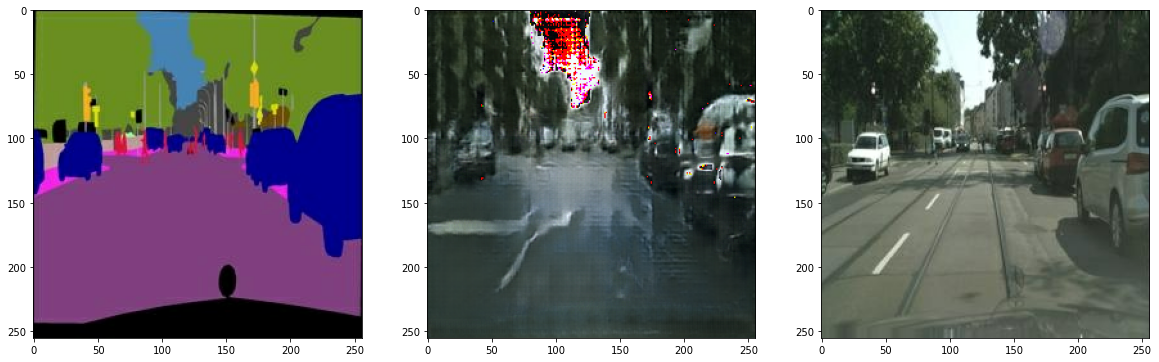

In [35]:
test_ind = 1

f = val_data_path + os.listdir(val_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

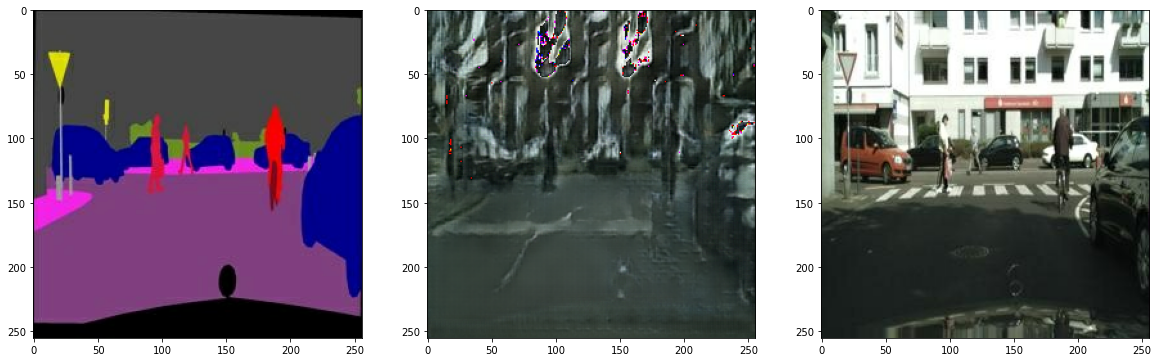

In [36]:
test_ind = 2

f = val_data_path + os.listdir(val_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

형태는 인식하는 것 같지만 조금더 학습시킬 필요가 있어보입니다.